In [8]:
import pandas as pd
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.regularizers import l2

In [4]:
df= pd.read_csv('/data/imdb_reviews_preprocessing18k.csv')

In [5]:
df.head()

,review,label,rating,word_counts,preprocessed_review
0,Although Humphrey Bogart got star billing in K...,0,3,325,although humphrey bogart got star billing king...
1,I probably give this more credit than it deser...,0,2,492,probably give credit deserves halloween knott ...
2,Something to Sing About was produced at Grand ...,0,4,386,something sing produced grand national studio ...
3,This film is strictly for fans of Debbie Reyno...,0,3,436,film strictly fan debbie reynolds eddie fisher...
4,I went to this movie expecting a concise movie...,0,2,103,went movie expecting concise movie relating ef...


In [11]:
# Loại bỏ các giá trị NaN hoặc không phải chuỗi từ cột 'preprocessed_review'
df = df.dropna(subset=['preprocessed_review'])
df = df[df['preprocessed_review'].apply(lambda x: isinstance(x, str))]

In [33]:
df.describe()

,label,rating,word_counts
count,18496.000000,18496.000000,18496.000000
mean,1.189230,5.538279,220.883164
std,0.833007,2.585263,178.268699
min,0.000000,1.000000,1.000000
25%,0.000000,4.000000,114.000000
50%,1.000000,6.000000,166.000000
75%,2.000000,7.000000,277.000000
max,2.000000,10.000000,1714.000000


In [28]:
df.shape

(18496, 5)

In [12]:
# Tạo một đối tượng Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['preprocessed_review'])

# Chuyển đổi văn bản thành các chỉ số
sequences = tokenizer.texts_to_sequences(df['preprocessed_review'])
print(sequences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
vocab_size = len(tokenizer.word_index) + 1

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 250
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
# Khởi tạo EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Chuẩn bị dữ liệu đầu vào cho mô hình
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], stratify = df['label'],test_size=0.2, random_state=42)
from imblearn.over_sampling import SMOTE

# Khởi tạo SMOTE
smote = SMOTE(random_state=42)

# Áp dụng SMOTE cho dữ liệu huấn luyện
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Hiển thị số lượng lớp sau khi áp dụng SMOTE
print("Số lượng lớp train chưa áp dụng SMOTE:")
print(y_train.value_counts())
print("Số lượng lớp train sau khi áp dụng SMOTE:")
print(y_train_smote.value_counts())

Số lượng lớp train chưa áp dụng SMOTE:
label
2    6798
1    4000
0    3998
Name: count, dtype: int64
Số lượng lớp train sau khi áp dụng SMOTE:
label
2    6798
1    6798
0    6798
Name: count, dtype: int64


In [23]:
# Xây dựng mô hình
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 150
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(units=32))
model2.add(Dense(units=3, activation='softmax'))

# Biên soạn mô hình
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test) , callbacks=[early_stopping])

Epoch 1/50
463/463 [==============================] - 54s 112ms/step - loss: 1.0669 - accuracy: 0.4588 - val_loss: 1.0605 - val_accuracy: 0.4595
Epoch 2/50
463/463 [==============================] - 51s 111ms/step - loss: 1.0364 - accuracy: 0.4754 - val_loss: 1.0603 - val_accuracy: 0.4581
Epoch 3/50
463/463 [==============================] - 51s 111ms/step - loss: 0.9868 - accuracy: 0.5018 - val_loss: 1.1089 - val_accuracy: 0.4649
Epoch 4/50
463/463 [==============================] - 52s 112ms/step - loss: 0.9679 - accuracy: 0.5079 - val_loss: 1.1146 - val_accuracy: 0.4624
Epoch 5/50
463/463 [==============================] - 51s 110ms/step - loss: 0.9617 - accuracy: 0.5102 - val_loss: 1.1817 - val_accuracy: 0.4530
Epoch 6/50
463/463 [==============================] - 50s 109ms/step - loss: 0.9500 - accuracy: 0.5153 - val_loss: 1.1001 - val_accuracy: 0.4651
Epoch 7/50
463/463 [==============================] - 51s 110ms/step - loss: 0.8938 - accuracy: 0.5730 - val_loss: 1.0248 - val_ac

In [25]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

116/116 [==============================] - 2s 19ms/step - loss: 0.8471 - accuracy: 0.6686
Test Loss: 0.8471142649650574
Test Accuracy: 0.6686486601829529


In [37]:
from sklearn.metrics import classification_report
import numpy as np

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# In classification report
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print('Loss:', test_loss)
print('Accuracy:', test_accuracy)
print(classification_report(y_test, y_pred_classes))

116/116 [==============================] - 2s 19ms/step - loss: 0.8471 - accuracy: 0.6686
Loss: 0.8471142649650574
Accuracy: 0.6686486601829529
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1000
           1       0.63      0.63      0.63      1000
           2       0.70      0.73      0.71      1700

    accuracy                           0.67      3700
   macro avg       0.66      0.65      0.66      3700
weighted avg       0.67      0.67      0.67      3700



Confusion Matrix:
[[ 600  123  277]
 [ 100  634  266]
 [ 208  252 1240]]


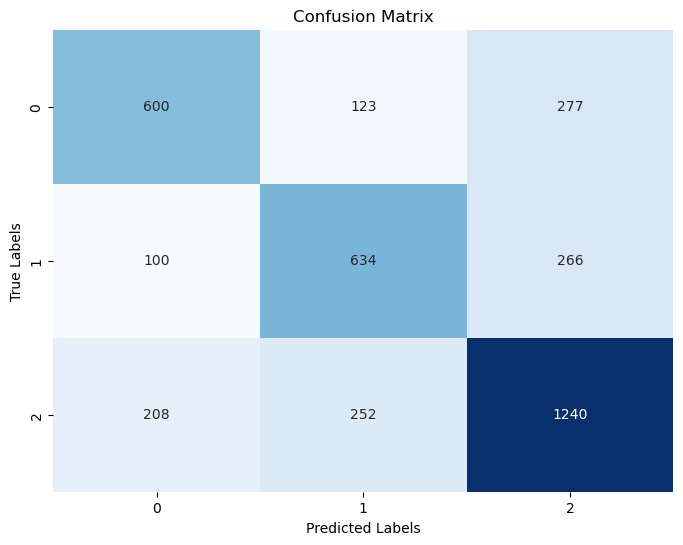

In [27]:
from sklearn.metrics import confusion_matrix

# Tính confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# In ra confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ heatmap từ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()